# Response to Reviewers
This notebook run additional analyses to address the reviewers' comments.

### imports and setups

In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (GridSearchCV, GroupShuffleSplit, GroupKFold,
                                     StratifiedGroupKFold, cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVR
from tqdm import tqdm

from src.sugnet.pipeline import FeatureExtractor

In [96]:
# helper functions
def classification_with_nestedCV(kind, frequency_band, power_type, X, y, groups,
                                 n_splits_outer=50, n_splits_inner=5, rand=False):
    y_preds = []

    # Choose cross-validation techniques for the inner and outer loops
    outer_cv = GroupShuffleSplit(n_splits=n_splits_outer, test_size=0.3)
    inner_cv = GroupShuffleSplit(n_splits=n_splits_inner, test_size=0.2)

    # PIPELINE
    pipe = Pipeline(steps=[
    ('extract', FeatureExtractor(power_types=power_type)),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])
    
    # grid search
    grid_params = [{
        'extract__kind': [kind],
        'extract__frequency_band': [frequency_band],
    }]
    
    test_accuraies = []
    for train, test in outer_cv.split(X, y, groups):
        
        if rand:
            random.shuffle(y)
        # Nested CV with parameter optimization
        grid = GridSearchCV(pipe, grid_params, cv=inner_cv, scoring='accuracy', verbose=0, n_jobs=-1)
        grid.fit(X[train], y[train], groups=groups.iloc[train])
        
        # accrucy on the test set using the best estimator
        y_pred = grid.predict(X[test])
        y_preds.append(y_pred)
        test_accuraies.append((y[test] == y_pred).mean())
        
    return test_accuraies, y_preds

def run_SVR(kind, frequency_band, power_type, X, y, groups, rand=False):
    mse_all = []
    r2_all = []
    
    cv = GroupKFold(5)
    n_iter = 40

    # PIPELINE
    pipe = Pipeline(steps=[
    ('extract', FeatureExtractor(kind=kind, frequency_band=frequency_band, power_types=power_type)),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('regr', LinearSVR(dual='auto', max_iter=1000000)),
    ])
    
    for i in range(n_iter):
        if rand:
            random.shuffle(y)
        for train, test in cv.split(X, y, groups):
            pipe.fit(X[train], y[train])

            mse = mean_squared_error(y[test], pipe.predict(X[test]))
            r2 = r2_score(y[test], pipe.predict(X[test]))

            mse_all.append(mse)
            r2_all.append(r2)

    return mse_all, r2_all

def plot_grid(grid_results, chance_scores, scale=2, annotate_points=True):

    grid_results = grid_results.melt()
    chance_scores = chance_scores.melt()
    uniques = grid_results.groupby('variable').mean().sort_values(by='value', ascending=False)
    order = grid_results.groupby('variable')['value'].mean().sort_values(ascending=False).index.values

    # fig, ax = plt.subplots(1, 1, figsize=(7, 9))

    # plot chance
    sns.pointplot(data=chance_scores, x='value', y='variable', order=order, orient='h',
                color='violet', linestyles='dotted', scale=1, capsize=0.1, 
                join=False, 
                label='Chance',
                dodge=True,
                errorbar=('ci', 99)
                )

    # plot observed
    g = sns.pointplot(data=grid_results, x='value', y='variable', order=order, orient='h', markers='D',
                color='forestgreen', scale=scale, join=False, capsize=0.1,
                label='Accuracy',
                dodge=True,
                errorbar=('ci', 99)
                )

    # annotate points
    if annotate_points:
        yticks = [tick.get_text() for tick in g.get_yticklabels()]
        for x, y_txt, txt in zip(uniques['value'].values, uniques.index, uniques['value'].values):
            y = yticks.index(y_txt)
            t = plt.text(x, y, round(txt, 2), horizontalalignment='center', verticalalignment='center',
                        fontdict={'color':'white', 'size':8, 'weight':'bold'})

    plt.xticks(fontsize=10)
    plt.xlabel('Values', fontsize=10)
    plt.ylabel('Measures', fontsize=10)
    plt.grid(axis='x', linestyle='--', color='gray', lw=2, alpha=0.5, zorder=0)


def run_classfication(kind, frequency_band, power_type, X, y, groups, n_splits=5, n_iter=40, kernel='linear'):
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True)

    # PIPELINE
    pipe = Pipeline(steps=[
    ('extract', FeatureExtractor(kind=kind, frequency_band=frequency_band, power_types=power_type)),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel=kernel)),
    ])
    
    scores = cross_val_score(pipe, X, y, groups=groups, cv=cv, n_jobs=-1)
    
    accs = np.array([])
    for i in range(n_iter):
        for train, test in cv.split(X, y, groups):
            pipe.fit(X[train], y[train])
            y_pred = pipe.predict(X[test])
            accs = np.append(accs, (y[test] == y_pred).mean())
        
    return accs

### Descriptive statistics

Text(0.5, 1.0, 'Hypnotizability Distribution')

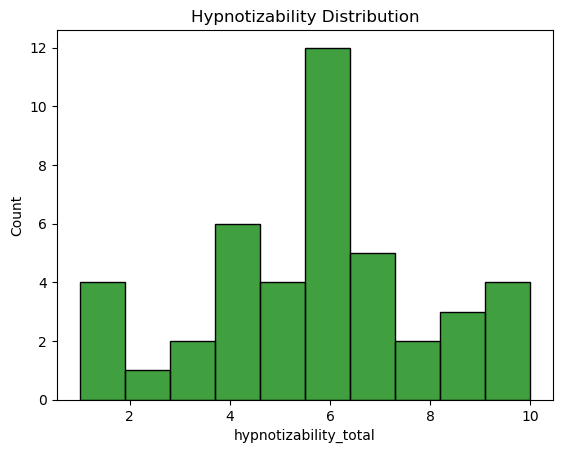

In [15]:
# open hypnotizability data
hypnotizability = pd.read_excel('data/behavioral_data/PLB_HYP_data_MASTER.xlsx').loc[9:, ['hypnotizability_total', 'bids_id']]
# hypnotizability histogram
sns.histplot(data=hypnotizability, x='hypnotizability_total', bins=10, color='green')
plt.title('Hypnotizability Distribution')

In [16]:
hypnotizability['hypnotizability_total'].describe()

count    43.00000
mean      5.72093
std       2.50072
min       1.00000
25%       4.00000
50%       6.00000
75%       7.00000
max      10.00000
Name: hypnotizability_total, dtype: float64

Text(0.5, 1.0, 'Hypnosis depth')

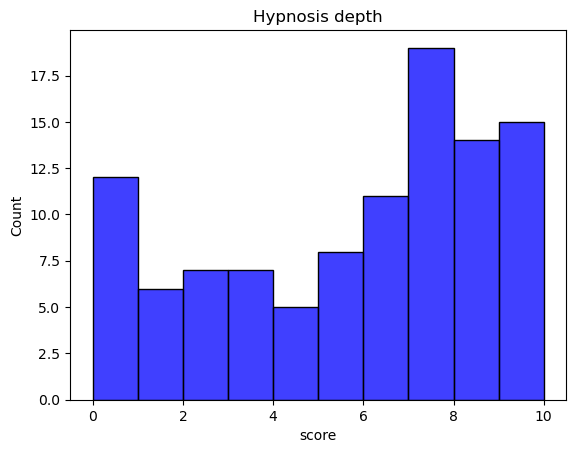

In [100]:
# open behavioral data in long format
data = pd.read_csv('data/behavioral_data/behavioral_data.csv')
data = data.query("description == 'hypnosis'")

# hypnosis depth histogram
sns.histplot(data=data, x='score', bins=10, color='blue')
plt.title('Hypnosis depth')

In [103]:
# the correlation between hypnotizability scores and hypnosis depth in all the conditions
data = pd.read_csv('data/behavioral_data/behavioral_data.csv')
data = data.query("description == 'hypnosis'").reset_index(drop=True)

hypnotizability = pd.read_excel('data/behavioral_data/PLB_HYP_data_MASTER.xlsx').loc[9:, ['bids_id', 'hypnotizability_total']]
hypnotizability = hypnotizability.loc[hypnotizability.index.repeat(2)].reset_index(drop=True)
data = pd.concat([data, hypnotizability], axis=1).dropna().reset_index(drop=True)
data[['hypnotizability_total', 'score']].corr()

,hypnotizability_total,score
hypnotizability_total,1.000000,0.580162
score,0.580162,1.000000


<Axes: xlabel='hypnotizability_total', ylabel='score'>

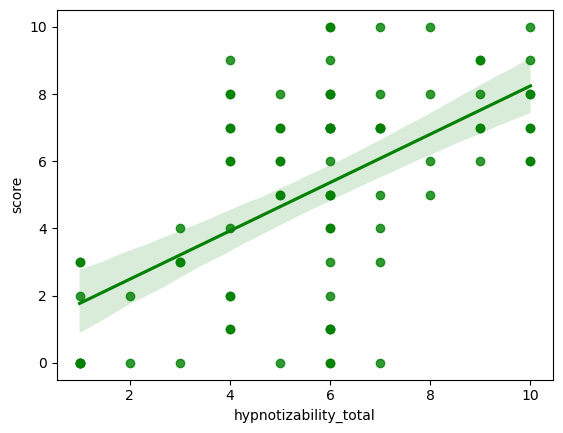

In [105]:
sns.regplot(data=data, x='hypnotizability_total', y='score', color='green')

### Analysis 1: using hypnotizability scores as target variable
In this section, we use the extracted features from the brain to predict hypnotizability classes. We use the same features and models as in the main paper, but instead of using hypnosis depth as the target variable, we use the hypnotizability scores.

In [41]:
# 1. open hypnotizability data
hypnotizability = pd.read_excel('data/behavioral_data/PLB_HYP_data_MASTER.xlsx').loc[9:, ['hypnotizability_total', 'bids_id']]
hypnotizability = hypnotizability.loc[hypnotizability.index.repeat(4)].reindex()
hypnotizability['bids_id'] = hypnotizability['bids_id'].astype(int)
hypnotizability = hypnotizability.iloc[:-2].reset_index(drop=True)

# 2. open behavioral data
# 1. Data
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)
DATA = DATA.query('condition.str.contains("experience")').reset_index(drop=True)

# 3. check if the order in the bids_id columns are the same across the two dataframes
if hypnotizability['bids_id'].equals(DATA['bids_id']):
    hypnotizability.drop(columns=['bids_id'], inplace=True)
    
    # 4. merge two dataframes
    DATA = pd.concat([DATA, hypnotizability], axis=1)
    DATA = DATA.query('description == "hypnosis"')
    DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))
else:
    print('The order of the bids_id columns are not the same across the two dataframes.')

DATA.dropna(inplace=True)

#### 1.1: hypnotizability scores as binary class + real hypnosis

In [ ]:
# 5. Xy
DATA = DATA.query('procedure == "relaxation" or procedure == "confusion"')
X = DATA[['bids_id','procedure']].values
median = DATA['hypnotizability_total'].median()
y = DATA['hypnotizability_total'].apply(lambda x: 'low' if x <=4 else 'medium' if x<8 else 'high').values
groups = DATA['bids_id']

# 6. nested cross validation
kinds = ['correlation source']
frequency_bands = ['beta']
models = [(i, j) for i in kinds for j in frequency_bands]
test_accuracies = {}
y_preds = {}

for model in models:
    kind = model[0]
    frequency_band = model[1]
    model_name = f'{kind} {frequency_band}'
    print('>>>>>', model_name)
    test_accuracy, y_pred = classification_with_nestedCV(kind, frequency_band, 'absolute', X, y, groups)
    test_accuracies[model_name] = test_accuracy
    y_preds[model_name] = y_pred

df = pd.DataFrame(test_accuracies)
# df.to_csv('data/classification_results/binary_real_hypnosis.csv', index=False)

In [71]:
df.mean().sort_values(ascending=False)

correlation source alpha    0.627692
power sensor gamma          0.627692
power source delta          0.616923
power sensor beta           0.607692
correlation source beta     0.606154
power source beta           0.598462
power source gamma          0.593846
correlation source gamma    0.590769
correlation source theta    0.580000
power source alpha          0.576923
correlation sensor gamma    0.563077
power sensor delta          0.544615
correlation sensor theta    0.540000
power source theta          0.530769
power sensor alpha          0.524615
wpli source theta           0.524615
wpli sensor gamma           0.515385
power sensor theta          0.512308
wpli sensor alpha           0.512308
wpli source gamma           0.506154
wpli source delta           0.503077
wpli source alpha           0.503077
correlation sensor delta    0.487692
correlation sensor alpha    0.484615
correlation sensor beta     0.478462
correlation source delta    0.466154
wpli source beta            0.464615
w

In [72]:
unique, counts = np.unique(y, return_counts=True) 
unique_groups = dict(zip(unique, counts))
print('>>> chance_level=', unique_groups[1] / len(y) * 100)

>>> chance_level= 61.904761904761905


#### 1.2: hypnotizability scores divided into two classes + conditions: labeled as hypnosis

In [98]:
X = DATA[['bids_id','procedure']].values
median = DATA['hypnotizability_total'].median()
y = DATA['hypnotizability_total'].apply(lambda x: 'low' if x<median else 'high').values
groups = DATA['bids_id']

# 6. nested cross validation
kinds = ['correlation source', 'power sensor', 'power source', 'wpli source']
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
models = [(i, j) for i in kinds for j in frequency_bands]
test_accuracies = {}

for model in models:
    kind = model[0]
    frequency_band = model[1]
    model_name = f'{kind} {frequency_band}'
    print('>>>>>', model_name)
    test_accuracy, y_pred = classification_with_nestedCV(kind, frequency_band, 'absolute', X, y, groups)
    test_accuracies[model_name] = test_accuracy

df = pd.DataFrame(test_accuracies)
save_path = 'data/classification_results/using_hypnotizability_scores/binary_labeled_hypnosis.csv'
# df.to_csv(save_path, index=False)

In [23]:
# chance level
DATA['hypnotizability_total'].apply(lambda x: 'low' if x<median else 'high').value_counts(normalize=True)

hypnotizability_total
high    0.611765
low     0.388235
Name: proportion, dtype: float64

In [21]:
df.mean().sort_values(ascending=False)

correlation source beta     0.641262
power sensor gamma          0.623908
correlation source alpha    0.609692
power source theta          0.570677
power source alpha          0.566338
correlation source gamma    0.561477
power source gamma          0.553046
power source delta          0.551969
power source beta           0.543477
wpli source delta           0.538985
power sensor beta           0.531969
power sensor theta          0.526123
power sensor delta          0.520277
wpli source alpha           0.493969
power sensor alpha          0.492092
correlation source theta    0.489046
wpli source gamma           0.480215
wpli source theta           0.464554
correlation source delta    0.460831
wpli source beta            0.455846
dtype: float64

In [99]:
# is the accuracy, for the top models, significantly higher than chance level?
kinds = ['correlation source', 'power sensor', 'correlation source']
frequency_bands = ['beta', 'gamma', 'alpha']
random_accuracies = {}
for kind, band in zip(kinds, frequency_bands):
    print('>>>>>', kind, band)
    random_accuracy, _ = classification_with_nestedCV(kind, band, 'absolute', X, y, groups, rand=True)
    random_accuracies[f'{kind} {band}'] = random_accuracy
df_rnd = pd.DataFrame(random_accuracies)

>>>>> correlation source beta
>>>>> power sensor gamma
>>>>> correlation source alpha


In [100]:
df = pd.read_csv(save_path)[['correlation source beta', 'power sensor gamma', 'correlation source alpha']]

/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

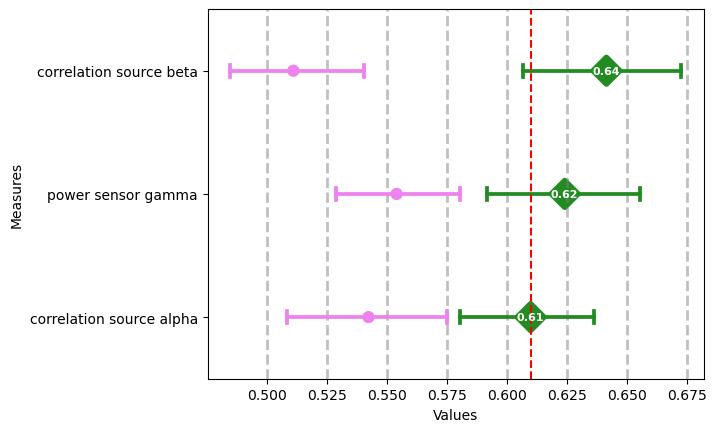

In [101]:
plot_grid(df, df_rnd, scale=2, annotate_points=True)
plt.axvline(0.61, color='red', linestyle='--')
plt.show()

#### 1.3: hypnotizability scores as a continuous variable + conditions labeled as hypnosis

In [ ]:
X = DATA[['bids_id','procedure']].values
median = DATA['hypnotizability_total'].median()
y = DATA['hypnotizability_total'].values
groups = DATA['bids_id']

# 6. nested cross validation
kinds = ['correlation source', 'power sensor', 'power source', 'wpli source']
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
models = [(i, j) for i in kinds for j in frequency_bands]
mse = {}
r2 = {}

for model in models:
    kind = model[0]
    frequency_band = model[1]
    model_name = f'{kind} {frequency_band}'
    print('>>>>>', model_name)
    mse_, r2_ = run_SVR(kind, frequency_band, 'absolute', X, y, groups, rand=False)
    mse[model_name] = mse_
    r2[model_name] = r2_

df1 = pd.DataFrame(mse)
df1.columns = [f'{col} (mse)' for col in df1.columns]
df2 = pd.DataFrame(r2)
df2.columns = [f'{col} (r2)' for col in df2.columns]
df = pd.concat([df1, df2], axis=1)
# save_path = 'data/classification_results/using_hypnotizability_scores/continious_labeled_hypnosis.csv'
# df.to_csv(save_path, index=False)

In [34]:
df.mean().sort_values(ascending=False)

correlation source alpha (mse)    27.558750
correlation source delta (mse)    25.333037
power source beta (mse)           24.625822
power source alpha (mse)          24.625244
power source delta (mse)          24.620527
power source theta (mse)          24.615720
power source gamma (mse)          24.615643
wpli source gamma (mse)           24.468380
correlation source theta (mse)    23.974717
wpli source theta (mse)           23.090891
wpli source beta (mse)            20.791207
wpli source delta (mse)           19.282328
wpli source alpha (mse)           18.125492
power sensor gamma (mse)          14.782789
power sensor beta (mse)           13.314085
correlation source gamma (mse)    11.645358
correlation source beta (mse)     11.306216
power sensor alpha (mse)           9.095806
power sensor delta (mse)           8.331641
power sensor theta (mse)           7.904820
power sensor alpha (r2)           -0.696436
power sensor delta (r2)           -0.727436
power sensor theta (r2)         

#### 1.4: hypnotizability scores divided into three classes + conditions: labeled as hypnosis

In [ ]:
X = DATA[['bids_id','procedure']].values
y = DATA['hypnotizability_total'].apply(lambda x: 'low' if x <=4 else 'medium' if x<8 else 'high').values
groups = DATA['bids_id']

# 6. nested cross validation
kinds = ['correlation source', 'power sensor', 'power source', 'wpli source']
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
models = [(i, j) for i in kinds for j in frequency_bands]
test_accuracies = {}

for model in models:
    kind = model[0]
    frequency_band = model[1]
    model_name = f'{kind} {frequency_band}'
    print('>>>>>', model_name)
    test_accuracy, _ = classification_with_nestedCV(kind, frequency_band, 'absolute', X, y, groups)
    test_accuracies[model_name] = test_accuracy

df = pd.DataFrame(test_accuracies)
# save_path = 'data/classification_results/using_hypnotizability_scores/three_class_labeled_hypnosis.csv'
# df.to_csv(save_path, index=False)

In [18]:
# chance level
y = DATA['hypnotizability_total'].apply(lambda x: 'low' if x <=4 else 'medium' if x<8 else 'high')
y.value_counts(normalize=True)

hypnotizability_total
medium    0.494118
low       0.294118
high      0.211765
Name: proportion, dtype: float64

In [14]:
df.mean().sort_values(ascending=False)

power sensor theta          0.424123
power sensor beta           0.423508
power source gamma          0.403446
correlation source theta    0.401354
wpli source gamma           0.398677
wpli source beta            0.387354
power sensor delta          0.385815
power source delta          0.379200
power source beta           0.379046
power source alpha          0.374462
power source theta          0.369600
wpli source theta           0.363046
power sensor gamma          0.362246
power sensor alpha          0.361015
wpli source delta           0.356862
correlation source alpha    0.350215
correlation source delta    0.345231
wpli source alpha           0.339723
correlation source beta     0.301938
correlation source gamma    0.293292
dtype: float64

### Analysis 2: regression (Linear SVR) with hypnosis depth as target variable

In [3]:
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)
DATA = DATA.query('condition.str.contains("experience")').reset_index(drop=True)
DATA = DATA.query('description == "hypnosis"')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))
DATA.reset_index(drop=True, inplace=True)

# Xy
X = DATA[['bids_id', 'procedure']].values
y = DATA['hypnosis_depth'].values
groups = DATA['bids_id']

In [ ]:
# regression using SVR
frequency_bands = ['delta', 'theta','alpha', 'beta', 'gamma']
kinds = ['power sensor', 'power source', 'wpli source', 'correlation source']
models = [(i, j) for i in kinds for j in frequency_bands]

mse_all = {}
r2_all = {}

for model in models:
    kind = model[0]
    frequency_band = model[1]
    model_name = f'{kind} {frequency_band}'
    print('>>>>>', model_name)
    mse, r2 = run_SVR(kind=kind, frequency_band=frequency_band, power_type='absolute',
                      X=X, y=y, groups=groups, rand=True)
    mse_all[model_name] = np.hstack(mse)
    r2_all[model_name] = np.hstack(r2)

In [34]:
mse_df_rnd = pd.DataFrame(mse_all)
r2_df_rnd = pd.DataFrame(r2_all)

/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

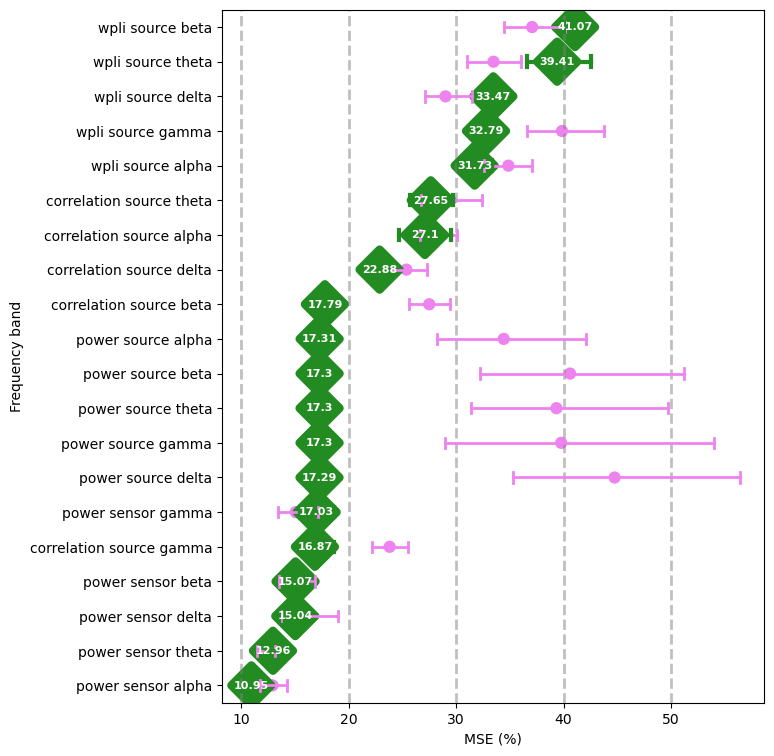

In [49]:
plot_grid(mse_df, mse_df_rnd, scale=3, annotate_points=True)

In [50]:
r2_df.mean().sort_values(ascending=False)

power sensor alpha         -0.310940
power sensor theta         -0.537040
power sensor beta          -0.767597
power sensor delta         -0.782003
correlation source gamma   -0.854422
power sensor gamma         -0.927492
power source delta         -1.076037
power source gamma         -1.076557
power source theta         -1.076986
power source beta          -1.077526
power source alpha         -1.077722
correlation source beta    -1.102330
correlation source delta   -1.770044
correlation source theta   -2.277058
correlation source alpha   -2.279610
wpli source alpha          -2.722175
wpli source gamma          -3.102904
wpli source delta          -3.130157
wpli source theta          -3.407668
wpli source beta           -4.167235
dtype: float64

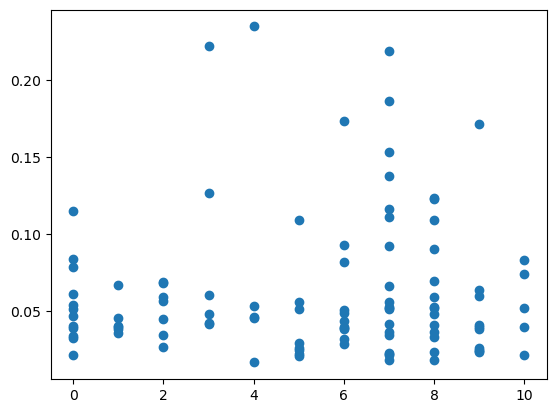

In [18]:
power = FeatureExtractor(kind='power sensor', frequency_band='gamma', power_types='absolute').fit_transform(X, y)

plt.plot(y, power['CZ_gamma'], 'o')

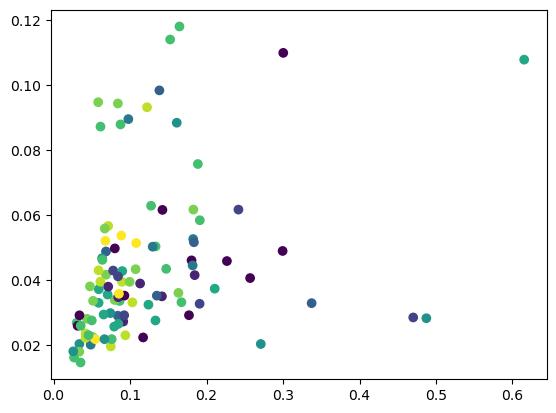

In [21]:
# y_ = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values
plt.scatter(power['FZ_gamma'], power['PZ_gamma'], c=y, cmap='viridis')

### Analysis 3: regression (XGBoost) with hypnosis depth as target variable

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

In [53]:
params = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 2,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

mse_all = []
r2_all = []
cv = GroupKFold(5)
n_iter = 40

# PIPELINE
pipe = Pipeline(steps=[
('extract', FeatureExtractor(kind='power sensor', frequency_band='gamma', power_types='absolute')),
('zerovar', VarianceThreshold(threshold=0.0)),
('scale', StandardScaler()),
('regr', GradientBoostingRegressor(**params)),
])

for i in range(n_iter):
    for train, test in cv.split(X, y, groups):
        # random.shuffle(y)
        pipe.fit(X[train], y[train])
        mse = mean_squared_error(y[test], pipe.predict(X[test]))
        r2 = r2_score(y[test], pipe.predict(X[test]))
        mse_all.append(mse)
        r2_all.append(r2)

### Analysis 4: Multiclass classification

In [38]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# load data
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)
DATA = DATA.query('condition.str.contains("experience")').reset_index(drop=True)
DATA = DATA.query('description == "hypnosis"')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))
DATA.reset_index(drop=True, inplace=True)

# Xy
X = DATA[['bids_id', 'procedure']].values
# one-hot encoding of hypnosis depth
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 3 else 1 if x <= 7 else 2).astype('category')
y = OneHotEncoder().fit_transform(y.values.reshape(-1, 1)).toarray()
groups = DATA['bids_id']

In [99]:
# useing mlp regressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

pipe = Pipeline(steps=[
    ('extract', FeatureExtractor(kind='power sensor', frequency_band='gamma', power_types='absolute')),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('regr', MLPClassifier(max_iter=1000000)),
])

acc = np.array([])
cv = GroupKFold(5)
n_iter = 10

for i in range(n_iter):
    for train, test in cv.split(X, y, groups):
        pipe.fit(X[train], y[train])
        acc = np.append(acc, f1_score(y[test], pipe.predict(X[test]), average='weighted'))

### Analysis 5: Relative powers

#### 5.1: use sham conditions labeled as relaxation for normalization

In [23]:
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)
DATA = DATA.query('condition.str.contains("experience")').reset_index(drop=True)
DATA = DATA.query('description == "hypnosis"')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))

DATA['is_it_real'] = DATA['procedure'].apply(lambda x: 'real' if x == 'relaxation' or x == 'confusion' else 'sham')
X = DATA.query('is_it_real == "real"')[['bids_id','procedure']].values
groups = DATA.query('is_it_real == "real"')['bids_id']

DATA.set_index('bids_id', inplace=True)
real = DATA.query('is_it_real == "real"')['hypnosis_depth']
sham = DATA.query('is_it_real == "sham"')['hypnosis_depth']

y = (real+1)/(sham+1)[:-1]
y = y.values

In [ ]:
# regression
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
mse_all = {}
r2_all = {}

for frequency_band in frequency_bands:
    print('>>>>>', frequency_band)
    mse, r2 = run_SVR('power sensor relative to sham', frequency_band, X, y, groups, rand=True)
    mse_all[frequency_band] = np.hstack(mse)
    r2_all[frequency_band] = np.hstack(r2)

In [48]:
df_mse = pd.DataFrame(mse_all)
df_r2 = pd.DataFrame(r2_all)
df_mse_rnd = pd.DataFrame(mse_all)
df_r2_rnd = pd.DataFrame(r2_all)
mse = df_mse.melt()
uniques = mse.groupby('variable').mean().sort_values(by='value', ascending=False)
# open chance scores
chance_scores = df_mse_rnd.melt(var_name='label', value_name='test_score')

/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

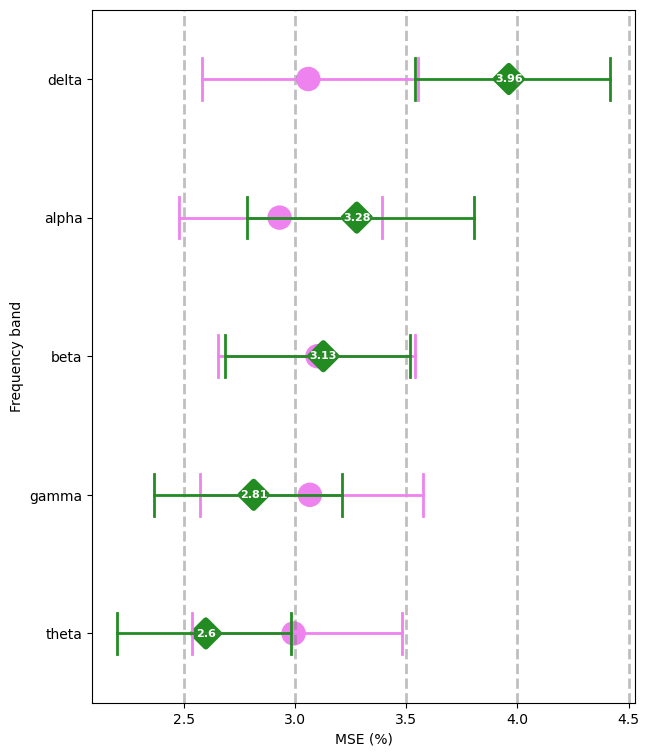

In [58]:
plot_mes(mse, chance_scores, uniques)

#### 5.2: use sham conditions labeled as relaxation for normalization

#### 5.3: using relative powers (relative to the baseline)

In [5]:
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)
DATA = DATA.query('condition.str.contains("experience")').reset_index(drop=True)
DATA = DATA.query('description == "hypnosis"')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))

# Xy
X = DATA[['bids_id', 'procedure']].values
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= 5 else 1).values
groups = DATA['bids_id']

In [ ]:
# regression
frequency_bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
accuracys = {}

for frequency_band in frequency_bands:
    print('>>>>>', frequency_band)
    accuracy, _ = classification_with_nestedCV(kind='power sensor', frequency_band=frequency_band, power_type='decibel',
                                           X=X, y=y, groups=groups)
    accuracys[frequency_band] = accuracy

In [10]:
pd.DataFrame(accuracys).mean()

delta    0.514153
theta    0.469032
alpha    0.507177
beta     0.465000
gamma    0.534738
dtype: float64

### Analysis 6: interaction effects and effect sizes in ANOVAs

In [3]:
%reload_ext autoreload
%autoreload 3
import pandas as pd
import pingouin as pg

In [4]:
DATA = pd.read_excel('data/PLB_HYP_data_MASTER.xlsx')
DATA = DATA.dropna(subset='bids_id') # drop the first 9 participants

# Wide to Long
DATA = DATA.melt(id_vars=[
                          'procedure_type_1', 'procedure_type_2', 'procedure_type_3', 'procedure_type_4', 'bids_id',
                          'description_type_1', 'description_type_2', 'description_type_3', 'description_type_4',
                          'hypnosis_depth_1', 'hypnosis_depth_2', 'hypnosis_depth_3', 'hypnosis_depth_4',
                          'trial_type_1', 'trial_type_2', 'trial_type_3', 'trial_type_4'
                          ],
                 value_vars=['expectancy_1', 'expectancy_2', 'expectancy_3', 'expectancy_4']
                 )

DATA['session'] = DATA['variable'].apply(lambda x:x.split('_')[1])
DATA['procedure'] = DATA.apply(lambda r:r['procedure_type_'+r['session']], axis=1)
DATA['description'] = DATA.apply(lambda r:r['description_type_'+r['session']], axis=1)
DATA['hypnosis_depth'] = DATA.apply(lambda r:r['hypnosis_depth_'+r['session']], axis=1)
DATA['trial_type'] = DATA.apply(lambda r:r['trial_type_'+r['session']], axis=1)

DATA = DATA[['bids_id', 'session', 'trial_type', 'procedure', 'description', 'value', 'hypnosis_depth',]].sort_values(by=['bids_id', 'session'])
DATA = DATA.rename(columns={'value': 'expectancy'})
DATA.reset_index(drop=True, inplace=True)

# replace true values with strings (having boolean values will affect ANOVA result)
DATA = DATA.replace({True: 'real'})

In [9]:
# two-ways anova 
aov = pg.anova(data=DATA, dv='hypnosis_depth', between=['trial_type', 'description'], detailed=True)
aov.round(4)

,Source,SS,DF,MS,F,p-unc,np2
0,trial_type,55.0433,1,55.0433,6.5706,0.0111,0.0312
1,description,374.2356,1,374.2356,44.6733,0.0000,0.1796
2,trial_type * description,2.5433,1,2.5433,0.3036,0.5822,0.0015
3,Residual,1708.9423,204,8.3772,NaN,NaN,NaN


In [10]:
aov = pg.anova(data=DATA, dv='expectancy', between=['trial_type', 'description'], detailed=True)
aov.round(4)

,Source,SS,DF,MS,F,p-unc,np2
0,trial_type,0.2356,1,0.2356,0.0419,0.8380,0.0002
1,description,612.7356,1,612.7356,109.0605,0.0000,0.3484
2,trial_type * description,3.0048,1,3.0048,0.5348,0.4654,0.0026
3,Residual,1146.1346,204,5.6183,NaN,NaN,NaN


### Snsitivity Analysis: change cuttoff in hypnosis depth categorization

formula of Macro and Weighted average:
Macro avg = (f1_0 + f1_1) / 2
Weighted avg = (f1_0 x support_0 + f1_1 x support_1) / (support_0 + support_1)

In [3]:
# imports & define helper functions
from sklearn.model_selection import cross_validate
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_recall_fscore_support,
                             recall_score, precision_score, f1_score,
                             classification_report)

In [53]:
def run_classfication(kind, frequency_band, power_type, X, y, groups, n_splits=5, n_iter=1):
    
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True)

    pipe = Pipeline(steps=[
    ('extract', FeatureExtractor(kind=kind, frequency_band=frequency_band, power_types=power_type)),
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear')),
    ])

    reports = pd.DataFrame([])
    acc = np.array([])
    recalls = np.array([])

    for i in range(n_iter):
        for train, test in cv.split(X, y, groups):
            pipe.fit(X[train], y[train])
            y_pred = pipe.predict(X[test])
            
            # recall_scores
            recalls = np.append(recalls, recall_score(y[test], y_pred, average='macro',
                                                      zero_division=np.nan))
            
            # accuracy
            acc = np.append(acc, accuracy_score(y[test], y_pred))
            
            # report
            report = pd.DataFrame(classification_report(y[test],
                                                        y_pred,
                                                        output_dict=True,
                                                        zero_division=np.nan))
            report.rename(columns={'0': 'low', '1': 'high'}, inplace=True)

            reports = pd.concat([reports, _wide_to_long(report)], axis=1)
    index = np.arange(0, n_iter * n_splits, 1)
    reports = reports.T.set_index(index)
    # values in 'recall_accuracy' is the same as the other accuracy columns, so let's drop them and keep only one
    reports.drop(columns=['precision_accuracy', 'f1-score_accuracy', 'support_accuracy'], inplace=True)
    reports.rename(columns={'recall_accuracy': 'accuracy'}, inplace=True)

    return reports, acc, recalls  # we return the accuracy and recall scores for sanity check

def _wide_to_long(df):
    df = df.stack().reset_index()
    df['variable'] = df['level_0'] + '_' + df['level_1']
    return df.drop(columns=['level_0', 'level_1']).set_index('variable')

# plotting
def _include_exclude(df_cols, criteria):
    cols = []
    for i in criteria:
        col = df_cols[df_cols.str.contains(i)].values
        cols += list(col)
    return cols

def _add_baseline_line(series, thr, color='gray'):
    y = series.apply(lambda x: 0 if x <= thr else 1)
    baseline = y.value_counts(normalize=True).max()
    plt.axvline(baseline, color=color, linestyle='--', lw=2, alpha=1)
    
    
def plot_result(df, thr, color='g', include='all', exclude=[], scale=2, marker='D',
                baseline=True, annotate_points=True):

    df = df.loc[thr]

    if include != 'all':   
        df = df[_include_exclude(df.columns, include)]
    if exclude:
        df = df.drop(columns=_include_exclude(df.columns, exclude))

    df = df.melt()
    order = df.groupby('variable')['value'].mean().sort_values(ascending=False).index.values
    uniques = df.groupby('variable').mean().sort_values(by='value', ascending=False)
    
    g = sns.pointplot(data=df,
                      x='value',
                      y='variable',
                      order=order,
                      color=color,
                      orient='h',
                      label=thr,
                      scale=scale,
                      join=False,
                      markers=marker)
    if baseline:
        _add_baseline_line(DATA['hypnosis_depth'], thr, color=color)
    
    # annotate points
    if annotate_points:
        yticks = [tick.get_text() for tick in g.get_yticklabels()]
        for x, y_txt, txt in zip(uniques['value'].values, uniques.index, uniques['value'].values):
            y = yticks.index(y_txt)
            t = plt.text(x, y, round(txt, 2), horizontalalignment='center', verticalalignment='center',
                        fontdict={'color':'white', 'size':8, 'weight':'bold'})

    plt.xticks(fontsize=10)
    plt.xlabel('Values', fontsize=10)
    plt.ylabel('Measures', fontsize=10)
    plt.grid(axis='x', linestyle='--', color='gray', lw=2, alpha=0.5, zorder=0)

In [7]:
# changing threshold for the hypnosis depth
DATA = pd.read_csv('docs/plb_hyp_data_long.csv', index_col=0)
DATA = DATA.query('condition.str.contains("experience")').reset_index(drop=True)
DATA = DATA.query('description == "hypnosis"')
DATA['bids_id'] = DATA['bids_id'].apply(lambda x: str(x).rjust(2, '0'))
DATA.reset_index(drop=True, inplace=True)

# Xy
X = DATA[['bids_id', 'procedure']].values
groups = DATA['bids_id']

In [8]:
cutoffs = [4, 5, 6]

reports = {}
accs = {}
recalls = {}
for thr in cutoffs:
    print('>>>>>', thr)
    y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= thr else 1)
    report, acc, recall = run_classfication('power sensor', 'gamma', 'absolute', X, y, groups, n_iter=20)
    reports[thr] = report
    accs[thr] = acc
    recalls[thr] = recall

df_cutoffs = pd.concat(reports, axis=0, keys=cutoffs)

>>>>> 4
>>>>> 5
>>>>> 6


/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

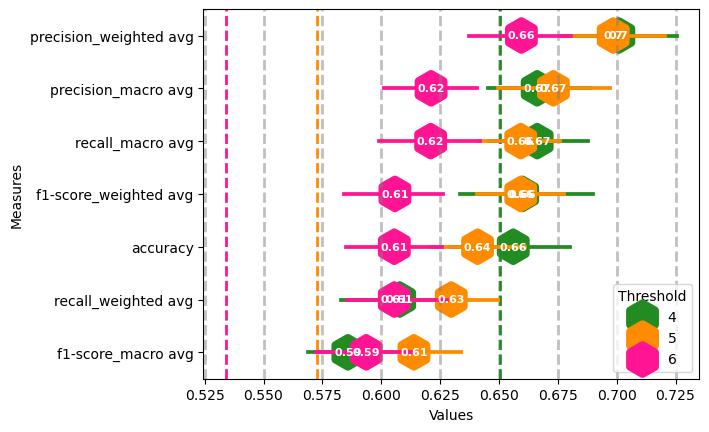

In [68]:
colors = ['forestgreen', 'darkorange', 'deeppink']
for thr, color in zip(cutoffs, colors):
    plot_result(df_cutoffs,
                thr,
                color=color,
                include=['accuracy', 'weighted avg', 'macro avg'],
                exclude=['support'],
                scale=3,
                marker='h')
plt.legend(title='Threshold')

In [ ]:
# TODO: run sensitivity analysis using differnt types of
# cross validation (including nested classification)
# TODO: for each threshold run the random, chance level.

/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/SugNet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWar

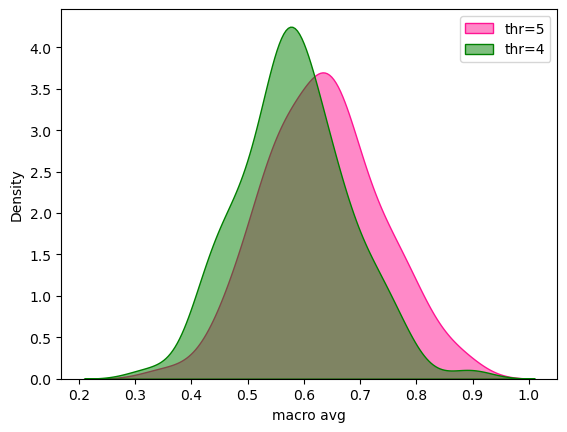

In [157]:
recall_macro_5 = pd.concat(reports, axis=0, keys=thrs).loc[5].loc['recall', 'macro avg']
recall_macro_4 = pd.concat(reports, axis=0, keys=thrs).loc[4].loc['recall', 'macro avg']
sns.kdeplot(data=recall_macro_5, fill=True, color='deeppink', alpha=0.5, label='thr=5')
sns.kdeplot(data=recall_macro_4, fill=True, color='g', alpha=0.5, label='thr=4')
plt.legend()
plt.show()